In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as  np
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    top_k_accuracy_score,
    log_loss,
    cohen_kappa_score,
    precision_recall_curve,
    average_precision_score
)




In [3]:
# Load your file
df = pd.read_csv("data1.csv")

# Rename first column if needed
df.rename(columns={df.columns[0]: 'disease'}, inplace=True)

# Combine all symptom columns into a single column
symptom_cols = df.columns[1:]  # all columns except 'disease'
df['symptoms'] = df[symptom_cols].apply(lambda row: ', '.join(row.dropna().astype(str)), axis=1)

# Keep only the cleaned version
df_clean = df[['disease', 'symptoms']]
print(df_clean.head())

            disease                                           symptoms
0  Fungal infection  itching,  skin_rash,  nodal_skin_eruptions,  d...
1  Fungal infection   skin_rash,  nodal_skin_eruptions,  dischromic...
2  Fungal infection  itching,  nodal_skin_eruptions,  dischromic _p...
3  Fungal infection          itching,  skin_rash,  dischromic _patches
4  Fungal infection         itching,  skin_rash,  nodal_skin_eruptions


In [4]:
# Step 2: Encode labels
label_encoder = LabelEncoder()
df_clean['label'] = label_encoder.fit_transform(df_clean['disease'])

/var/folders/25/742ql2290p5fzbqhth18lbzm0000gn/T/ipykernel_66832/2596293214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['label'] = label_encoder.fit_transform(df_clean['disease'])


In [5]:
# Step 3: Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_clean['symptoms'], df_clean['label'], test_size=0.2, random_state=42
)

In [6]:
# Step 4: Load BioBERT tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [7]:
# Step 5: Prepare HuggingFace Datasets
train_dataset = HFDataset.from_dict({
    'text': train_texts.tolist(),
    'label': train_labels.tolist()
})
test_dataset = HFDataset.from_dict({
    'text': test_texts.tolist(),
    'label': test_labels.tolist()
})

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map: 100%|██████████| 984/984 [00:00<00:00, 22147.07 examples/s]


In [8]:
# Step 6: Load BioBERT model
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Step 7: Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no"
)

/Users/pankhuri/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
# Step 8: Define metrics
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    return {"accuracy": (preds == pred.label_ids).mean()}

In [11]:
# Step 9: Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [12]:
# Step 10: Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.097900,0.062441,1.000000
2,0.019600,0.013462,1.000000
3,0.015400,0.010241,1.000000


TrainOutput(global_step=738, training_loss=0.4154161822686835, metrics={'train_runtime': 1551.4999, 'train_samples_per_second': 7.611, 'train_steps_per_second': 0.476, 'total_flos': 443119016712384.0, 'train_loss': 0.4154161822686835, 'epoch': 3.0})

In [13]:
# Step 11: Evaluate
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)


Evaluation Results: {'eval_loss': 0.010240625590085983, 'eval_accuracy': 1.0, 'eval_runtime': 20.7781, 'eval_samples_per_second': 47.357, 'eval_steps_per_second': 2.984, 'epoch': 3.0}


In [14]:
# Step 12: Classification report
y_pred = trainer.predict(test_dataset).predictions.argmax(-1)
print("\nClassification Report:\n")
print(classification_report(test_labels, y_pred, target_names=label_encoder.classes_))


Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold       1.00      1.00      1.00        23
  

In [41]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("data1.csv")
df.rename(columns={df.columns[0]: 'disease'}, inplace=True)
symptom_cols = df.columns[1:]

# Combine all symptoms into a list
df['symptom_list'] = df[symptom_cols].values.tolist()

# Function to generate a basic sentence
def make_sentence(symptoms):
    clean = [s for s in symptoms if pd.notna(s)]
    return "I’ve been experiencing " + ", ".join(clean[:-1]) + " and " + clean[-1] + "."

# Apply to create a new column
df['symptoms_text'] = df['symptom_list'].apply(make_sentence)

# Final cleaned DataFrame
df_final = df[['symptoms_text', 'disease']]
print(df_final.head())


                                       symptoms_text           disease
0  I’ve been experiencing itching,  skin_rash,  n...  Fungal infection
1  I’ve been experiencing  skin_rash,  nodal_skin...  Fungal infection
2  I’ve been experiencing itching,  nodal_skin_er...  Fungal infection
3  I’ve been experiencing itching,  skin_rash and...  Fungal infection
4  I’ve been experiencing itching,  skin_rash and...  Fungal infection


In [67]:
df_final.to_csv("phase3_natural_symptoms.csv", index=False)


In [68]:
import random

# Optional: Inject paraphrasing and light noise to test generalization
synonym_map = {
    "fatigue": ["tiredness", "exhaustion", "feeling drained"],
    "high fever": ["burning up", "really hot", "severe fever"],
    "vomiting": ["throwing up", "nausea", "puking"],
    "nausea": ["queasiness", "feeling sick"],
    "pain": ["discomfort", "ache", "soreness"],
    "headache": ["throbbing head", "migraine", "head pain"]
}

# def paraphrase(sentence):
#     for word, alternatives in synonym_map.items():
#         if word in sentence:
#             for alt in alternatives:
#                 if random.random() < 0.2:
#                     sentence = sentence.replace(word, alt)
#                     break
#     return sentence

# def drop_symptom(sentence):
#     symptoms = sentence.split(", ")
#     if len(symptoms) > 3:
#         symptoms.pop(random.randint(0, len(symptoms)-1))
#     return ", ".join(symptoms)


def heavy_paraphrase(sentence):
    for word, alternatives in synonym_map.items():
        if word in sentence:
            alt = random.choice(alternatives)
            sentence = sentence.replace(word, alt)
    return sentence

def heavy_drop_symptom(sentence):
    symptoms = sentence.split(", ")
    drop_count = min(2, len(symptoms) - 1)  # Drop up to 2 symptoms if possible
    for _ in range(drop_count):
        symptoms.pop(random.randint(0, len(symptoms)-1))
    return ", ".join(symptoms)



In [69]:
# Apply paraphrasing to test set only
df['symptoms_text'] = df['symptoms_text'].astype(str)
df['label'] = LabelEncoder().fit_transform(df['disease'])

X_train, X_test, y_train, y_test = train_test_split(
    df['symptoms_text'], df['label'], test_size=0.2, random_state=42
)

X_test_paraphrased = X_test.apply(paraphrase).apply(drop_symptom)

In [70]:
# # Step 1: Load dataset with natural symptom sentences
# df = pd.read_csv("phase3_natural_symptoms.csv")

# # Step 2: Encode labels
# label_encoder = LabelEncoder()
# df['label'] = label_encoder.fit_transform(df['disease'])

# # Step 3: Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     df['symptoms_text'], df['label'], test_size=0.2, random_state=42
# )


In [71]:
# Step 4: Load BioBERT tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)


In [72]:
# Step 5: Prepare HuggingFace Datasets
train_dataset = HFDataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train.tolist()
})
test_dataset = HFDataset.from_dict({
    'text': X_test_paraphrased.tolist(),
    'label': y_test.tolist()
})

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


Map: 100%|██████████| 984/984 [00:00<00:00, 29166.01 examples/s]


In [73]:
# Step 6: Load BioBERT model
num_labels = len(set(df['label']))
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
# Step 7: Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no"
)


/Users/pankhuri/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [75]:
# Step 8: Define metrics
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    return {"accuracy": (preds == pred.label_ids).mean()}



In [76]:
# Step 9: Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [77]:
# Step 10: Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.121100,0.359090,0.930894
2,0.020500,0.245252,0.942073
3,0.015800,0.240493,0.942073


TrainOutput(global_step=738, training_loss=0.5157610112775955, metrics={'train_runtime': 10720.8438, 'train_samples_per_second': 1.101, 'train_steps_per_second': 0.069, 'total_flos': 479539757812032.0, 'train_loss': 0.5157610112775955, 'epoch': 3.0})

In [78]:
# Step 11: Evaluate
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)



Evaluation Results: {'eval_loss': 0.2404933124780655, 'eval_accuracy': 0.9420731707317073, 'eval_runtime': 95.184, 'eval_samples_per_second': 10.338, 'eval_steps_per_second': 0.651, 'epoch': 3.0}


In [79]:
# Step 12: Classification report
y_pred = trainer.predict(test_dataset).predictions.argmax(-1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      0.83      0.91        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       0.96      1.00      0.98        24
                    Alcoholic hepatitis       1.00      0.76      0.86        25
                                Allergy       0.96      1.00      0.98        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      0.94      0.97        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      0.95      0.98        21
                    Chronic cholestasis       0.62      1.00      0.77        15
                            Common Cold       1.00      1.00      1.00        23
  

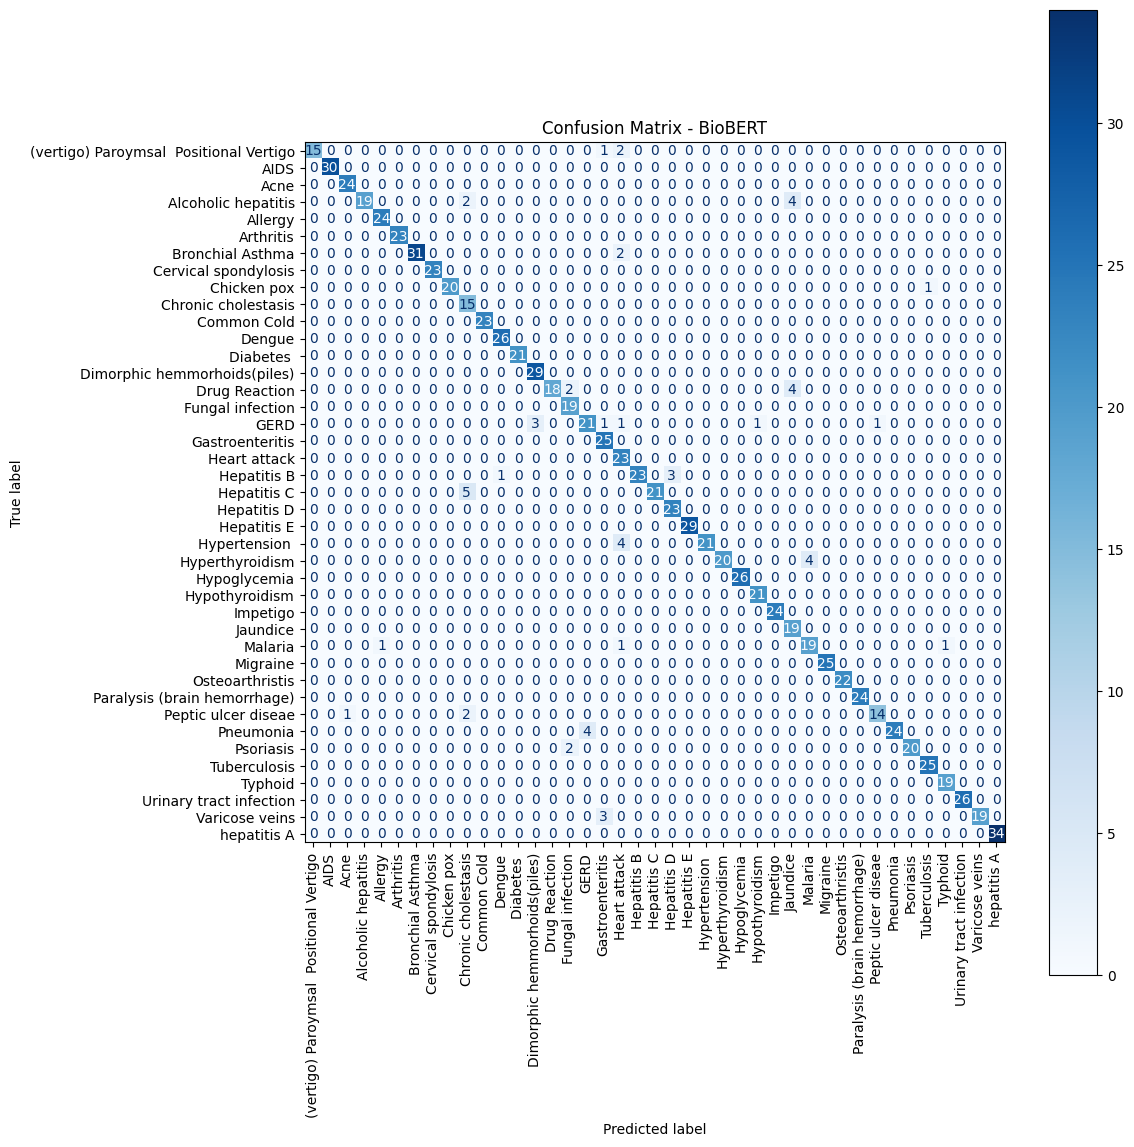

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 11: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LabelEncoder().fit(df['disease']).classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(xticks_rotation=90, ax=ax, cmap="Blues")
plt.title("Confusion Matrix - BioBERT")
plt.tight_layout()
plt.show()

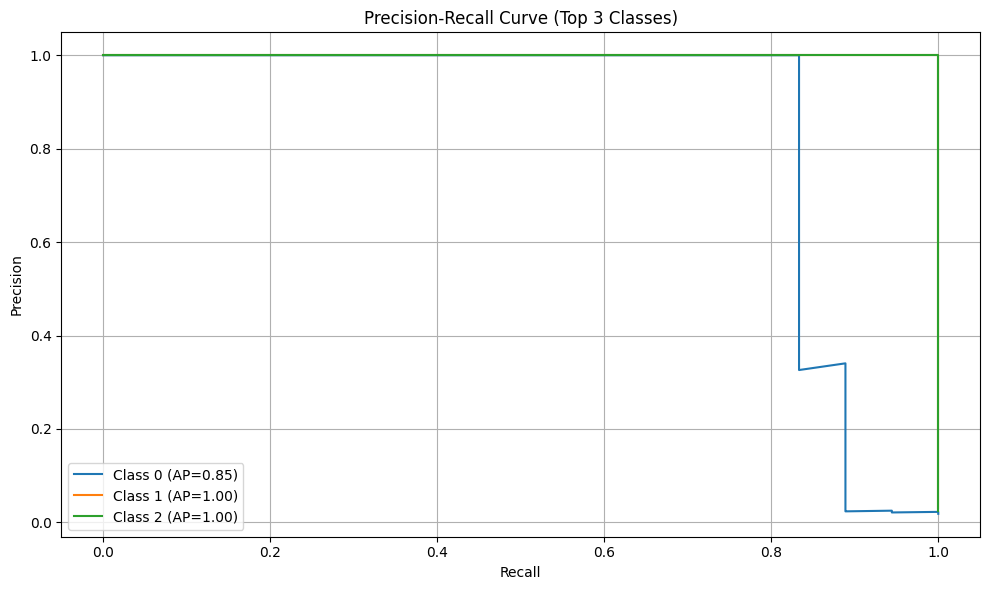

In [113]:
# Combined Precision-Recall Curve (Top 3 Classes)
plt.figure(figsize=(10, 6))
for i in [0, 1, 2]:
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Top 3 Classes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


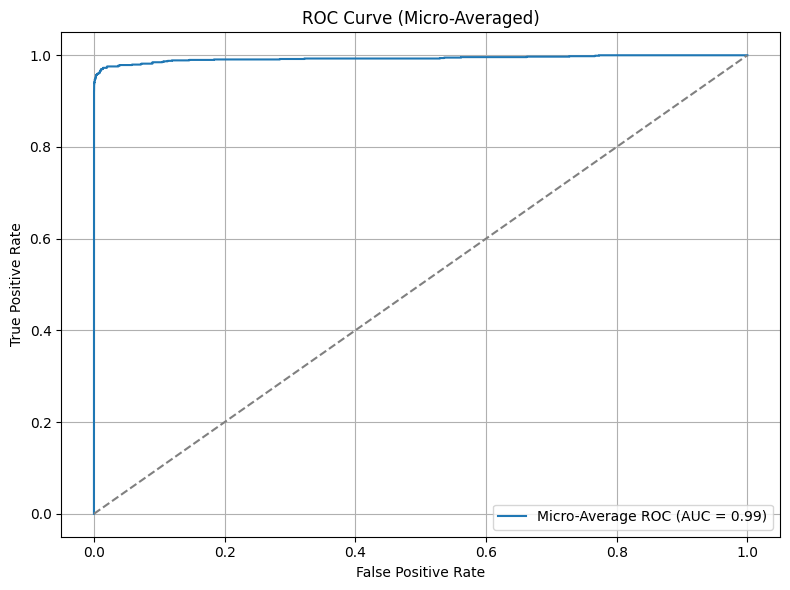

In [116]:
# ROC Curve (Micro-Averaged)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc = roc_auc_score(y_test_bin, y_score, average="micro")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Micro-Average ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-Averaged)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
# Top-3 Accuracy
print("Top-3 Accuracy:", top_k_accuracy_score(y_test, y_score, k=3))

# Log Loss
print("Log Loss:", log_loss(y_test, y_score))

# Cohen's Kappa Score
print("Cohen's Kappa Score:", cohen_kappa_score(y_test, y_pred))


Top-3 Accuracy: 0.9634146341463414
Log Loss: 0.12231095081263504
Cohen's Kappa Score: 0.940597079419951


/Users/pankhuri/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
# Step 13: Real-Time Prediction
def predict_symptom_sentence(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    label = LabelEncoder().fit(df['disease']).inverse_transform([pred])[0]
    return label

# Terminal-based loop for real-time input
while True:
    custom_input = input("\nEnter symptom description (or type 'exit' to quit): ")
    if custom_input.lower() == 'exit':
        break
    predicted_disease = predict_symptom_sentence(custom_input)
    print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Chronic cholestasis


In [ ]:
# I'm experiencing body aches, nausea, and yellowing of my skin and eyes.